# Creating crosslinked polymers with SwiftPol

Note: This is an experimental capability and will become integrated into SwiftPol's build module soon.

This code uses SwiftPol's framework to build a chain of Polyethylene Glycol Diacrylate (PEGDA) and build a large crosslinked polymer network with a degree of crosslinking controlled by function input.

Lukasz Sekula, 2025

In [1]:
# Imports
from rdkit import Chem
from rdkit.Chem import AllChem
import random

from swiftpol import build

In [2]:
def build_starting_polymer(sequence='ABBBBBBBBBA', 
                           monomers=["IC=CC(=O)OI", "IOCCOI"], 
                           polymer_reaction=AllChem.ReactionFromSmarts("[C:1]-[O:2]-[I:3].[C:4]-[O:5]-[I:6]>>[C:1]-[O:2]-[C:4].[I:3]-[I:6].[O:5]"), 
                           activation_reaction=AllChem.ReactionFromSmarts('[C:1]=[C:2].[Cl:3].[I:4]>>[C:1](-[I:4])-[C:2]-[Cl:3]')):
    """
    Builds a polymer and adds reactive sites.

    Parameters:
        - sequence (str): Polymer sequence
        - monomers (list): List of monomers (SMILES format)
        - polymer_reaction (rdkit reaction): Reaction to form the polymer
        - activation_reaction (rdkit reaction): Reaction to introduce reactive sites

    Returns:
        - starting_polymer (rdkit Mol): PEGDA polymer with reactive sites
    """
    #Build PEGDA polymer
    polymer = build.build_polymer(sequence=sequence, monomer_list=monomers, reaction=polymer_reaction)

    activatorCl = Chem.MolFromSmiles('Cl')
    activatorI = Chem.MolFromSmiles('I')

    # Apply activation reaction twice
    starting_polymer = activation_reaction.RunReactants([polymer, activatorCl, activatorI])[0][0]
    Chem.SanitizeMol(starting_polymer)

    starting_polymer = activation_reaction.RunReactants([starting_polymer, activatorCl, activatorI])[0][0]
    Chem.SanitizeMol(starting_polymer)

    Chem.AddHs(starting_polymer)
    return starting_polymer

starting_polymer = build_starting_polymer()

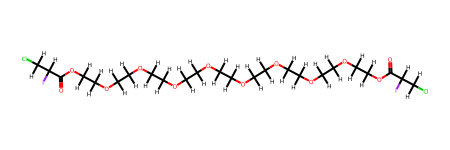

In [41]:
starting_polymer

In [3]:
def replace_halogens_with_hydrogens(mol):
    """
    Replaces all halogen atoms (F, Cl, Br, I) in an RDKit molecule with hydrogen atoms.

    This function iterates through the atoms in the given molecule, identifies halogen atoms 
    (fluorine, chlorine, bromine, iodine), removes them, and replaces them with explicit hydrogens. 
    The resulting molecule is sanitized and updated to ensure chemical validity.

    Parameters
    ----------
    mol : rdkit.Chem.Mol
        The input RDKit molecule from which halogens will be replaced with hydrogens.

    Returns
    -------
    rdkit.Chem.Mol
        A new RDKit molecule with all halogens replaced by explicit hydrogens.

    Notes
    -----
    - The function uses an editable RDKit molecule (RWMol) to modify the structure.
    - The molecule is sanitized after halogen removal to ensure chemical correctness.
    - Explicit hydrogens are added to the resulting molecule.
    """
    editable = Chem.RWMol(mol)   #Creates an editable version of an RDKit molecule
    halogen_atomic_nums = [9, 17, 35, 53]  #F, Cl, Br, I

    for atom in list(editable.GetAtoms()):  #list() to avoid issues
        if atom.GetAtomicNum() in halogen_atomic_nums:
            idx = atom.GetIdx()
            #Remove the halogen
            editable.RemoveAtom(idx)

    #Sanitize and add hydrogens back
    mol_no_halogens = editable.GetMol()
    mol_no_halogens.UpdatePropertyCache()
    Chem.SanitizeMol(mol_no_halogens)

    #Add explicit hydrogens
    mol_with_h = Chem.AddHs(mol_no_halogens)
    return mol_with_h


In [38]:
def build_crosslinked_polymer(starting_polymer, 
                              num_iterations=1, 
                              probability_of_crosslinked_addition=0.5, 
                              probability_of_linear_addition=0.5):
    """
    Builds a crosslinked polymer network by iteratively applying chemical reactions.

    This is an experimental capability - proceed with caution.

    This function simulates the growth of a polymer network by either adding linear chains 
    or crosslinking existing polymer chains. The user can specify the number of iterations 
    and the probabilities of crosslinking versus linear chain addition. The resulting polymer 
    is returned with halogens replaced by hydrogens for chemical completeness.

    Parameters
    ----------
    starting_polymer : rdkit.Chem.Mol
        The initial polymer molecule to start the crosslinking or chain addition process.
    num_iterations : int, optional
        The number of reaction iterations to perform (default is 1).
    probability_of_crosslinked_addition : float, optional
        The probability of performing a crosslinking reaction in each iteration (default is 0.5).
    probability_of_linear_addition : float, optional
        The probability of performing a linear chain addition reaction in each iteration (default is 0.5).

    Returns
    -------
    rdkit.Chem.Mol
        The final polymer molecule after the specified number of iterations, with halogens replaced by hydrogens.

    Raises
    ------
    AssertionError
        If the sum of `probability_of_crosslinked_addition` and `probability_of_linear_addition` is not equal to 1.

    Notes
    -----
    - The function uses predefined reaction templates (SMARTS) for crosslinking and chain addition.
    - Crosslinking requires at least two polymer chains to be present in the history.
    - The function randomly selects reactions and reactants based on the specified probabilities.
    - Halogens in the final polymer are replaced with hydrogens for chemical validity.

    Examples
    --------
    >>> from rdkit import Chem
    >>> starting_polymer = build.build_starting_polymer()
    >>> final_polymer = build_crosslinked_polymer(starting_polymer, num_iterations=5, 
    ...                                           probability_of_crosslinked_addition=0.6, 
    ...                                           probability_of_linear_addition=0.4)
    """
    # Check if the probabilities sum to 1
    if probability_of_crosslinked_addition + probability_of_linear_addition != 1:
        raise AssertionError("Probabilities must sum to 1.")
    #Define the reaction parameters
    activatorF = Chem.MolFromSmiles('F')
    activatorBr = Chem.MolFromSmiles('Br')

    reaction_templates = [
        ('[Cl:1]-[*:2]-[*:3](-[I:4])-[*:7].[Cl:8]-[*:9]-[*:10](-[I:11])-[*:12].[F:15].[F:16]>>[*:12]-[*:10](-[F:15])-[*:9]-[*:2]-[*:3](-[F:16])-[*:7].[Cl:1].[I:4].[Cl:8].[I:11]', (activatorF, activatorF)),
        ('[*:2]-[*:4](-[F:5])-[*:6]-[*:7]-[*:8](-[F:9])-[*:10].[Cl:13]-[*:14]-[*:15](-[I:16])-[*:17].[Br:20]>>[*:2]-[*:4](-[Br:20])-[*:6]-[*:7]-[*C:8](-[*:10])-[*:14]-[*:15](-[I:16])-[*:17].[Cl:1].[F:9].[F:5]', (activatorBr,)),
        ('[*:2]-[*:4](-[Br:5])-[*:6]-[*:7]-[*:8](-[*:9]-[*:12]-[*:13](-[I:14])-[*:15]).[Cl:18]-[*:19]-[*:20](-[I:21])-[*:22]>>[*:2]-[*:4]-[*:19]-[*:20](-[I:21])-[*:22]-[*:6]-[*:7]-[*:8](-[*:9]-[*:12]-[*:13](-[I:14])-[*:15]).[Br:5].[Cl:18]', ()),
        ('[*:2]-[*:4](-[F:5])-[*:6]-[*:7]-[*:8](-[F:9])-[*:10].[*:14]-[*:16](-[F:17])-[*:18]-[*:19]-[*:20](-[F:21])-[*:22]>>[*:2]-[*:4](-[*:16](-[*:14])(-[*:18]-[*:19]-[*:20](-[F:21])-[*:22]))-[*:6]-[*:7]-[*:8](-[F:9])-[*:10].[F:5].[F:17]', ()),
    ]

    #Convert SMARTS strings into RDKit reactions
    reactions = [(AllChem.ReactionFromSmarts(smarts), reactants) for smarts, reactants in reaction_templates]
        
    polymer_network = starting_polymer  #This is the main polymer we modify
    polymer_history = [polymer_network]  #Stores each iteration of the polymer network

    successful_reactions = 0
    while successful_reactions < num_iterations:
        #Choose whether to add a chain or crosslink
        action = random.choices(["add_chain", "crosslink"], weights=[probability_of_linear_addition, probability_of_crosslinked_addition], k=1)[0]

        if action == "crosslink":
            #Ensure crosslinking only happens when there's something to crosslink with
            if len(polymer_history) < 2:
                continue  #Skip this step and retry

            #Choose a previous polymer to crosslink with
            chosen_polymer = random.choice(polymer_history[:-1])  #Select from earlier polymer versions
            chosen_reaction, chosen_reactants = random.choices(reactions, weights=[0.0,0.3,0.35,0.35], k=1)[0]
            reactant_sequence = (polymer_network, chosen_polymer) + chosen_reactants  #Use current and chosen polymer

        else:  #Adding a chain
            chosen_reaction, chosen_reactants = reactions[0]
            reactant_sequence = (polymer_network, starting_polymer) + chosen_reactants  #Add chain to current polymer

        #Apply the reaction
        reactant_sets = chosen_reaction.RunReactants(reactant_sequence)

        if not reactant_sets:
            continue  #Retry without counting this attempt

        #Choose one of the successful products
        polymer_network = random.choice(reactant_sets)[0]
        polymer_history.append(polymer_network)  #Save the new polymer version
        successful_reactions += 1  #Count successful reactions

    return replace_halogens_with_hydrogens(polymer_history[-1])  #Return last polymer in the history


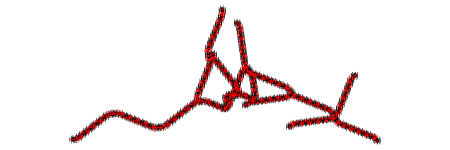

In [40]:
# A crossliked polymer with 50:50 linear to crosslinked ratio
build_crosslinked_polymer(starting_polymer, num_iterations=10, probability_of_crosslinked_addition=0.5, probability_of_linear_addition=0.5)

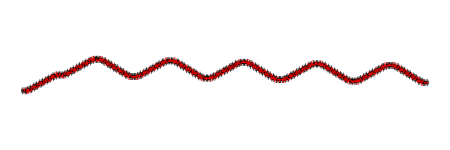

In [35]:
# A polymer with 0% crosslinked chains
build_crosslinked_polymer(starting_polymer, num_iterations=10, probability_of_crosslinked_addition=0, probability_of_linear_addition=1.0)

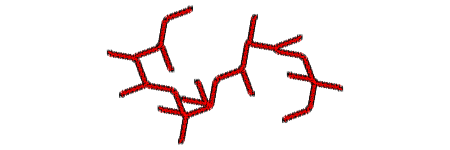

In [36]:
# A polymer with 20:80 crosslinked to linear ratio
build_crosslinked_polymer(starting_polymer, num_iterations=10, probability_of_crosslinked_addition=0.8, probability_of_linear_addition=0.2)